In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.7/901.7 kB 52.4 MB/s eta 0:00:00


Loading data to colab

In [3]:
!cp -r "/content/drive/Othercomputers/My laptop/GoogleDriveShared/val.7z" /content/

In [6]:
# or for tar file
!cp -r "/content/drive/Othercomputers/My laptop/GoogleDriveShared/val.tar" /content/

In [ ]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 37.2 MB/s eta 0:00:00


In [ ]:
# import py7zr

# with py7zr.SevenZipFile("/content/val.7z", 'r') as archive:
#      archive.extract(path="/content")

In [9]:
# slightly faster method
# !7z x /content/val.7z -o/content
!tar -xf /content/val.tar -C /content

In [10]:
!cp -r "/content/drive/Othercomputers/My laptop/GoogleDriveShared/train.7z" /content/

In [11]:
!7z x /content/train.7z -o/content


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 10077028742 bytes (9611 MiB)

Extracting archive: /content/train.7z
--
Path = /content/train.7z
Type = 7z
Physical Size = 10077028742
Headers Size = 406569
Method = LZMA2:24
Solid = +
Blocks = 3

  0%      0% 964 - train/labels/1120_896_448.txt                                          0% 1406 - train/labels/1185_896_1344.txt                                            0% 1743 - train/labels/126_896_1792.txt                                         

In [ ]:
# import py7zr

# with py7zr.SevenZipFile("/content/train.7z", 'r') as archive:
#      archive.extract(path="/content")

In [14]:
from ultralytics import YOLO
import torch
from tqdm import tqdm
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [15]:

def plot_image_with_bboxes(image_path, label_path):
    """
    Display an image with bounding boxes drawn based on YOLO labels.

    Args:
    - image_path (str): Path to the image file.
    - label_path (str): Path to the YOLO label file corresponding to the image.
    """
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Get image dimensions
    height, width, _ = image.shape

    # Read YOLO label file
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # Draw bounding boxes
    for label in labels:
        parts = label.strip().split()
        class_id, x_center, y_center, box_width, box_height = map(float, parts)

        # Denormalize the coordinates
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height

        # Calculate top-left and bottom-right corners
        x_min = int(x_center - box_width / 2)
        y_min = int(y_center - box_height / 2)
        x_max = int(x_center + box_width / 2)
        y_max = int(y_center + box_height / 2)

        # Draw the bounding box
        color = (255, 0, 0)  # Red color for bounding boxes
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, f'Class {int(class_id)}', (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    # plt.axis('off')
    plt.show()

In [16]:
# create folders if not exist
folder_crops = {'train': '/content/train/images/',
                'val': '/content/val/images/'}

folder_labels = {'train': '/content/train/labels/',
                 'val': '/content/val/labels/'}


def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

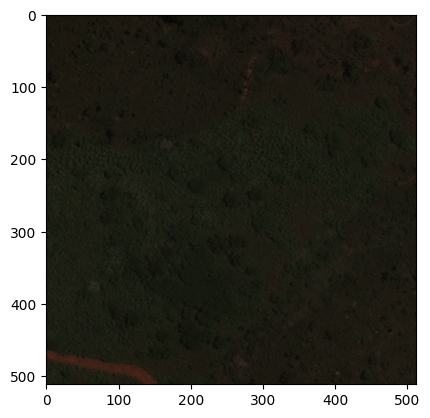

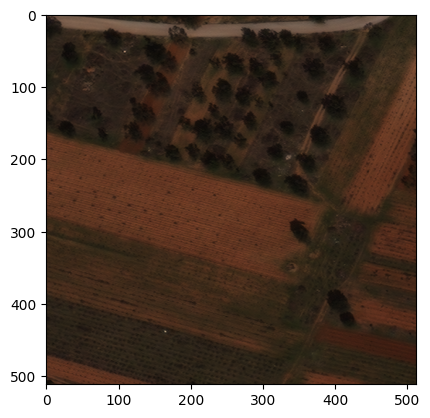

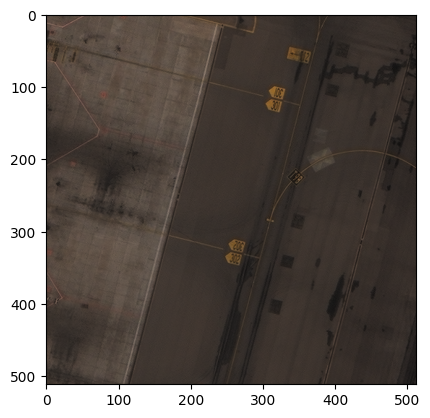

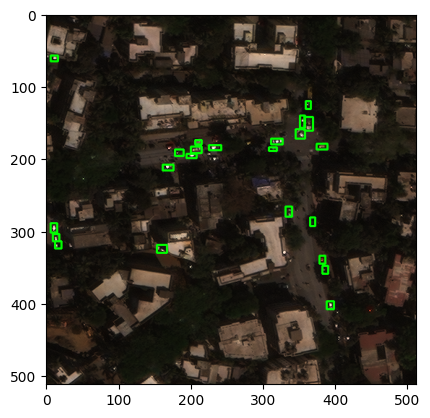

In [17]:
crop_size = 512
for idx, sample in enumerate(np.random.choice(os.listdir(folder_crops['train']), 4)):

    # Load image and corresponding labels
    image = imread(os.path.join(folder_crops['train'], sample))
    with open(os.path.join(folder_labels['train'], sample.replace('.tif', '.txt')), 'r') as f:
        labels = f.readlines()

    for box in labels:
        box = np.array([d for d in box.split(' ')], dtype=np.float32)

        # Undo coordinate normalization
        x_center = box[1] * crop_size
        y_center = box[2] * crop_size

        width = box[3] * crop_size
        height = box[4] * crop_size

        # Convert from YOLOv8 format to OpenCV rectangle format
        x_start, y_start = int(x_center - width/2), int(y_center - height/2)
        x_end, y_end = int(x_center + width/2), int(y_center + height/2)

        cv2.rectangle(image, (x_start, y_start), (x_end, y_end), color=(0, 255, 0), thickness=2)
    plt.figure()
    plt.imshow(image)

In [18]:
model = YOLO("yolov8s.pt")
model.info()

100%|██████████| 21.5M/21.5M [00:00<00:00, 43.1MB/s]


YOLOv8s summary: 225 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(225, 11166560, 0, 28.816844800000002)

In [ ]:
!yolo version


8.3.51


In [ ]:
# data.yaml was created and uploaded to colab
# config = """
# # train and val datasets (image directory or *.txt file with image paths)
# train: data/tif_images/train
# val: data/tif_images/val

# # number of classes
# nc: 2

# # class names
# names: ['Car/Bus', 'Truck']
# """

# with open("data.yaml", "w") as f:
#     f.write(config)

In [19]:
root = "/content"
!yolo task=detect mode=train model=yolov8s.pt data={root}/data.yaml epochs=10 imgsz=512 mosaic=0.0 flipud=0.5 scale=0.0

Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

In [20]:
import shutil

# Zip the folder
shutil.make_archive('runs', 'zip', 'runs')

from google.colab import files

# Download the zip file
files.download('runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Path to the folder containing the TIFF files
folder_path = Path("data/train_images")

# List all .tif files in the folder (including subfolders)
imfiles = list(folder_path.rglob("*.tif"))
# imfiles

In [ ]:
for idx, sample in enumerate(np.random.choice(imfiles, 4)):
    image = cv2.imread(sample)
    # image = image[1500:, 1500:, :]

    result = model.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 255, 0), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 6, cv2.LINE_AA)
    plt.figure(figsize=(10, 6))
    plt.imshow(image)

In [ ]:

if torch.cuda.is_available():
    print("CUDA is available. PyTorch will use the GPU.")
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch will use the GPU.
